Movie review sentiment classification using HuggingFace. Used Gemini as model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
reviews= pd.read_csv("/content/drive/MyDrive/reviews.csv")

In [3]:
reviews

,Rating,Review
0,7,(SPOILER FREE PART)\n\nIt feels like every Joh...
1,9,By now you know what to expect from a John Wic...
2,7,Think it's gone too far past how great JW1 was...
3,8,Most American action flicks released these day...
4,No rating,"From the very beginning to the end, nothing bu..."
...,...,...
1753,6,I don't want to leave the impression that I ha...
1754,8,"I don't get why this movie has a high score, i..."
1755,6,If you enjoy watching other people play video ...
1756,4,What is all the raving about with this movie? ...


In [ ]:
!pip install -U "huggingface_hub[cli]"

!pip install transformers
!pip install torch
!pip install -U bitsandbytes

AUTH_TOKEN = ""# fill in your token

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.6 MB/s eta 0:00:00


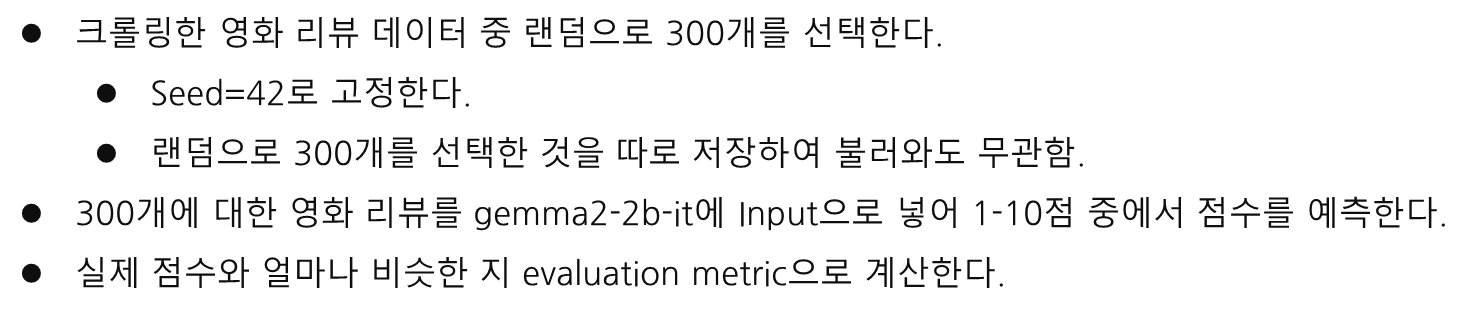

In [5]:
# "No rating"을 제외한 데이터 필터링
filtered_reviews = reviews[reviews['Rating'] != "No rating"]

# 랜덤 샘플링
sample_reviews = filtered_reviews.sample(n=300, random_state=42)

# 결과 확인
sample_reviews.head()

output_path = "/content/drive/MyDrive/sample_reviews.csv"
sample_reviews.to_csv(output_path, index=False, encoding="utf-8")

print(f"Sample reviews saved to {output_path}")

Sample reviews saved to /content/drive/MyDrive/sample_reviews.csv


In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import root_mean_squared_error
import torch

In [22]:
# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델과 토크나이저 불러오기
model_name = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=AUTH_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    use_auth_token=AUTH_TOKEN,
    load_in_8bit=True,
    device_map="auto"
)

# 실제 점수 리스트 생성
actual_scores = sample_reviews["Rating"].tolist()

# 예측 점수 리스트 초기화
predicted_scores = []

# Few-shot 예제 추가
few_shot_examples = """
Review: "The movie was absolutely fantastic, with great visuals and an amazing story."
Score: 9

Review: "I found the plot very boring, and the characters were poorly developed."
Score: 3

Review: "An enjoyable experience, but not without its flaws. The pacing could have been better."
Score: 7

Review: "Completely disappointing. I wouldn’t recommend it to anyone."
Score: 2

Review: "A true masterpiece. This film is a work of art."
Score: 10
"""

# 리뷰의 점수를 예측하는 코드
for review in sample_reviews["Review"]:
    prompt = f"""{few_shot_examples}
Review: "{review}"
Please output only the rating in this format:
Score: X
(where X is a number from 1 to 10)

Do not provide any other text."""

    # 텍스트를 토큰화하고 텐서로 변환
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # 모델로 추론하여 텍스트 생성
    outputs = model.generate(inputs.input_ids, max_new_tokens=10, num_return_sequences=1)

    # 생성된 텍스트 디코딩
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    score_text = generated_text.split("Score:")[-1].strip()  # 'Score:' 뒤의 텍스트만 추출

    try:
        # 예측된 점수를 float로 변환하여 리스트에 추가
        predicted_score = float(score_text)
        predicted_scores.append(predicted_score)
    except ValueError:
        # 예측된 점수가 숫자로 변환되지 않는 경우 예측에서 제외
        print(f"Invalid score prediction: {score_text}")
        predicted_scores.append(None)  # None으로 처리

    # 예측 점수 출력
    print(f"Review: {review}")
    print(f"Predicted Score: {score_text}")
    print("-" * 50)


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:809: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Review: Decent film. Although suspend belief is needed with alot of John Wick scenes they pushed it too far passed absurd on two occasions.

Two bits were just too annoying to let go. How can a blind man be accurate with a hand gun? Manic fight scenes where no way a blind man could sense enough too shoot and especially a pistol duel at 30 paces each. I can relate to being an amazing martial artist and swords man, but not a crack shot with a gun.

Two the German night club fight scene with hand axes, and initially gun shots. Dancers continued the most awful dancing whilst people where shot and then were being killed with axes next to them. A man died with an axe thrown at him hitting him in the head, between 2x dancers, and falls dead at the feet of 8x dancers but they show no signs of worry and carry on dancing. Only at the end after 20 odd people had died did they react and run away.
Predicted Score: 9
--------------------------------------------------
Review: This time around the spe

In [23]:
print(actual_scores)
print(predicted_scores)

['6', '8', '6', '2', '2', '5', '9', '6', '10', '10', '4', '9', '6', '8', '7', '2', '10', '4', '9', '3', '6', '8', '5', '9', '6', '9', '10', '7', '8', '1', '7', '7', '10', '5', '10', '4', '3', '4', '6', '3', '2', '8', '5', '2', '8', '3', '5', '3', '8', '5', '8', '7', '10', '9', '10', '2', '8', '8', '10', '3', '6', '8', '10', '5', '3', '3', '10', '10', '6', '2', '8', '4', '6', '9', '10', '1', '9', '4', '7', '7', '8', '8', '8', '9', '4', '7', '2', '8', '5', '8', '3', '2', '6', '6', '5', '1', '9', '9', '3', '1', '6', '6', '2', '10', '3', '5', '2', '5', '5', '1', '9', '1', '6', '9', '9', '4', '5', '6', '10', '2', '4', '1', '3', '10', '5', '8', '5', '4', '9', '7', '9', '10', '8', '6', '9', '10', '10', '5', '6', '10', '10', '3', '8', '5', '6', '5', '8', '1', '9', '4', '10', '5', '9', '6', '8', '2', '8', '6', '9', '10', '1', '10', '10', '9', '6', '3', '10', '10', '10', '8', '3', '8', '8', '8', '7', '9', '2', '6', '10', '10', '6', '10', '8', '9', '1', '10', '10', '9', '7', '10', '6', '1', '10',

In [24]:
# 예측값 중 None이 아닌 유효한 예측만을 사용하여 성능 평가
filtered_actual_scores = [float(a) for a, p in zip(actual_scores, predicted_scores) if p is not None]
filtered_predicted_scores = [p for p in predicted_scores if p is not None]
print(filtered_actual_scores)
print(filtered_predicted_scores)

[6.0, 8.0, 6.0, 2.0, 2.0, 5.0, 6.0, 4.0, 9.0, 6.0, 8.0, 7.0, 2.0, 4.0, 9.0, 3.0, 6.0, 8.0, 5.0, 9.0, 6.0, 10.0, 7.0, 8.0, 1.0, 7.0, 5.0, 4.0, 3.0, 4.0, 6.0, 3.0, 2.0, 8.0, 5.0, 2.0, 3.0, 5.0, 3.0, 8.0, 5.0, 8.0, 2.0, 8.0, 3.0, 6.0, 8.0, 5.0, 3.0, 3.0, 6.0, 2.0, 4.0, 6.0, 9.0, 1.0, 4.0, 7.0, 8.0, 8.0, 4.0, 2.0, 8.0, 5.0, 8.0, 3.0, 2.0, 6.0, 6.0, 1.0, 9.0, 3.0, 1.0, 6.0, 6.0, 2.0, 3.0, 2.0, 5.0, 5.0, 1.0, 9.0, 1.0, 9.0, 9.0, 4.0, 5.0, 6.0, 2.0, 4.0, 1.0, 3.0, 10.0, 5.0, 8.0, 5.0, 9.0, 7.0, 8.0, 6.0, 10.0, 5.0, 3.0, 5.0, 6.0, 5.0, 9.0, 4.0, 5.0, 9.0, 6.0, 8.0, 2.0, 6.0, 1.0, 10.0, 6.0, 3.0, 10.0, 8.0, 3.0, 8.0, 8.0, 7.0, 2.0, 6.0, 6.0, 10.0, 9.0, 7.0, 10.0, 6.0, 1.0, 4.0, 1.0, 2.0, 4.0, 6.0, 6.0, 4.0, 9.0, 3.0, 4.0, 4.0, 6.0, 7.0, 9.0, 8.0, 2.0, 2.0, 1.0, 7.0, 6.0, 3.0, 7.0, 10.0, 9.0, 7.0, 1.0, 6.0, 3.0, 6.0, 2.0, 5.0, 5.0, 9.0, 10.0, 10.0, 5.0, 6.0, 4.0, 10.0, 1.0, 5.0, 7.0, 6.0, 4.0, 10.0, 5.0, 4.0, 4.0, 5.0, 1.0, 7.0, 3.0, 2.0, 8.0, 5.0, 4.0, 4.0, 7.0, 1.0, 5.0, 8.0, 4.0, 7.0, 7.0, 9.

In [25]:
# RMSE 계산
rmse = root_mean_squared_error(filtered_actual_scores, filtered_predicted_scores)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 4.442150380164994


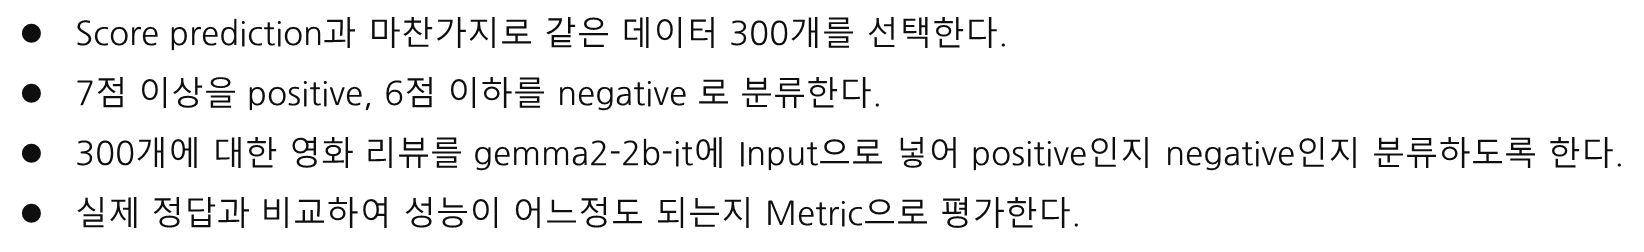

In [18]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
import torch

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델과 토크나이저 불러오기
model_name = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=AUTH_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    use_auth_token=AUTH_TOKEN,
    load_in_8bit=True,
    device_map="auto"
)
actual_labels=[]

# 실제 정답 라벨 생성
for score in sample_reviews["Rating"]:
    if int(score) >= 7:
        actual_labels.append(1)  # 긍정 리뷰
    else:
        actual_labels.append(0)  # 부정 리뷰

# 모델 예측 수행
predicted_labels = []
for review in sample_reviews["Review"]:
    prompt = f"""Review: "{review}"
    Classify this review as positive or negative. Positive if score >= 7, Negative if score <= 6.
    Follow the format below and do not provide any other text.
    Your Output: """

    # 텍스트를 토큰화하고 텐서로 변환
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # 모델로 텍스트 생성
    outputs = model.generate(inputs.input_ids, max_new_tokens=10, num_return_sequences=1)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # 'Your Output:' 뒤의 텍스트만 추출
    prediction = generated_text.split("Your Output:")[-1].strip().lower()
    if "positive" in prediction:
        predicted_labels.append(1)  # 긍정 리뷰
    elif "negative" in prediction:
        predicted_labels.append(0)  # 부정 리뷰
    else:
        predicted_labels.append(-1)  # 예측이 불확실한 경우 (필요시 사용)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
print("Actual labels(1 for positive, 0 for negative)")
print(actual_labels)
print("\nPredicted labels(1 for positive, 0 for negative)")
print(predicted_labels)

Actual labels(1 for positive, 0 for negative)
[0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]

Predicted labels(1 for positive, 0 for negative)
[0,

In [21]:
# 성능 평가
# 확실한 예측(positive 또는 negative)만을 평가함
filtered_actual = [label for label, pred in zip(actual_labels, predicted_labels) if pred != -1]
filtered_predicted = [pred for pred in predicted_labels if pred != -1]

# RMSE 계산
rmse = root_mean_squared_error(filtered_actual, filtered_predicted)

# Precision, Recall, F1 Score 계산
precision = precision_score(filtered_actual, filtered_predicted)
recall = recall_score(filtered_actual, filtered_predicted)
f1 = f1_score(filtered_actual, filtered_predicted)

# 결과 출력
print("Root Mean Squared Error (RMSE):", rmse)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Root Mean Squared Error (RMSE): 0.3
Precision: 0.9849624060150376
Recall: 0.8397435897435898
F1 Score: 0.9065743944636678
